# 데이터셋 불러오기

In [1]:
# IMA이미지를 불러오는 라이브러리
import pydicom

import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [3.0, 3.0]
import seaborn as sns
import torch.nn as nn

In [2]:
import glob

L_list = glob.glob('/root/Mayo2016/*')
L_list = [path.split('/')[-1] for path in L_list]
L_list.sort()
L_list

['L067',
 'L096',
 'L109',
 'L143',
 'L192',
 'L286',
 'L291',
 'L310',
 'L333',
 'L506']

In [3]:
data_label = ['quarter_1mm', 'full_1mm']

In [4]:
def normlize(path):
  dicom_data = pydicom.dcmread(path)
  img = dicom_data.pixel_array.astype(np.float32) * dicom_data.RescaleSlope + dicom_data.RescaleIntercept
  mu, sd = (-500,500)
  scaled_img = (img - mu) / sd
  img = np.expand_dims(scaled_img, axis=0)

  return img # 1x512x512

In [5]:
def extract_patches(img, patch_size=55, interval=55):
  patches = []
  _, height, width = img.shape
  for y in range(0, height - patch_size + 1, interval):
    for x in range(0, width - patch_size + 1, interval):
      patch = img[:, y:y + patch_size, x:x + patch_size]
      patches.append(patch)
  patches = np.array(patches)
  return patches # patch수x1x55x55

In [6]:
import random
from scipy.ndimage import rotate, zoom

def augment_patches(X_patches, y_patches, p=0.5):
    X_augmented_patches, y_augmented_patches = [], []
    
    # random이 들어가기에, X랑 y를 동시에 넣어준다.
    for i, (X_patch, y_patch) in enumerate(zip(X_patches, y_patches)):
        # 원본 패치 추가
        X_augmented_patches.append(X_patch)
        y_augmented_patches.append(y_patch)

        if random.random() < p:
            # 1. 90, 270으로 돌려보자.(뒤집기랑 조금 다르긴 하지만, 점대칭 vs 선대칭, 그냥 +-90도만 쓰자.)
            X, y = rotate(X_patch, 90, axes=(1, 2), reshape=False), rotate(y_patch, 90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
            X, y = rotate(X_patch, -90, axes=(1, 2), reshape=False), rotate(y_patch, -90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 2. 수직 뒤집기
            X,y = np.flip(X_patch, axis=1),np.flip(y_patch, axis=1)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 3. 수평 뒤집기
            X,y = np.flip(X_patch, axis=2),np.flip(y_patch, axis=2)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)

    return np.array(X_augmented_patches), np.array(y_augmented_patches)

In [7]:
def patch_maker_W_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  X_augmented_patches, y_augmented_patches = augment_patches(X_patches, y_patches, p=0.5)
  return X_augmented_patches, y_augmented_patches

In [8]:
def patch_maker_WO_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  return X_patches, y_patches

In [9]:
import os
from torch.utils.data import Dataset
import torch
import glob
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, L_list):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.L_list = L_list
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir
            y_dir_list += y_dir

        for X_dir, y_dir in tqdm(zip(X_dir_list, y_dir_list), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            for i in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[i]), torch.from_numpy(y_patches[i]) # torch로 넣어주자.
                self.image_pairs.append((X_patch, y_patch))

    def get_data_range(self, L):
        """슬라이싱 범위를 설정하는 함수"""
        X_dir = sorted(glob.glob(f'/root/Mayo2016/{L}/{data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'/root/Mayo2016/{L}/{data_label[1]}/*.IMA'))
        n1, n2 = len(X_dir), len(y_dir)
        
        if self.data_type == 'train':
            X_range = X_dir[:int(n1 * 0.64)]
            y_range = y_dir[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_dir[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_dir[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_dir[int(n1 * 0.8):]
            y_range = y_dir[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = self.image_pairs[idx][0]
        y = self.image_pairs[idx][1]
        return X, y

In [10]:
# 파일 경로 설정

root = '/root/code/'
train_path = root+'train_dataset.pt'
val_path = root+'val_dataset.pt'
test_path = root+'test_dataset.pt'

In [11]:
# 4분 정도 소요

# 데이터셋 불러오기
train_dataset = torch.load(train_path)
val_dataset = torch.load(val_path)
test_dataset = torch.load(test_path) # 45초

In [12]:
batch_size = 16
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [13]:
len(train_loader), len(val_loader), len(test_loader)

(57596, 4815, 6025)

# 모델

In [14]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        # 1. encoder 부분
        self.encoder = nn.ModuleList()
        # 2. decoder 부분
        self.decoder = nn.ModuleList()
        
        # Encoder: Down-sampling path
        for feature in features:
            self.encoder.append(self.conv_block(in_channels, feature)) # (1,64),(64,128),...,(256,512)
            in_channels = feature
        
        # Bottleneck
        self.bottleneck = self.conv_block(features[-1], features[-1] * 2) # ConvTranspose2d
        
        # Decoder: Up-sampling path
        for feature in reversed(features): # (512,256),...,(128,64)
            # encoder에서는 max_pool을 했지만, decoder에서는 max,mean도 아닌 그냥 conv를 이용해 사이즈를 pool의 반대로 만든다.
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self.conv_block(feature * 2, feature))
        
        # Final Convolution to match output channels
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1) # 64->1, 1x1-Conv

    def forward(self, x):
        enc_outputs = []
        
        # Encoder path
        for layer in self.encoder:
            x = layer(x)
            enc_outputs.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2) # feature map 사이즈를 절반으로 줄인다.
        
        # Bottleneck
        x = self.bottleneck(x) # 512 -> 1024
        
        # Decoder path
        for idx in range(0, len(self.decoder), 2): # 0,2,4 <- max-pool의 결과가 아닌 conv의 결과만 가져오기위해
            x = self.decoder[idx](x)  # Upsample
            enc_output = enc_outputs[-(idx // 2) - 1]  # Skip connection; -1,-2,-3
            x = F.interpolate(x, size=enc_output.shape[2:], mode='bilinear', align_corners=False) # encoder와 사이즈를 동일하게 맞춘다.
            # input 사이즈가 2의 제곱수가 아니기 때문에 넣어주어야한다.
            x = torch.cat((enc_output, x), dim=1)  # Concatenate encoder output
            x = self.decoder[idx + 1](x)  # Convolution after concatenation
        
        return self.final_conv(x)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), # feature map 사이즈 유지
            # nn.BatchNorm2d(out_channels),  # Add normalization for stability
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            # nn.BatchNorm2d(out_channels),  # Add normalization for stability
            nn.ReLU(inplace=True)
        )

In [16]:
# Example usage
model = UNet(in_channels=1, out_channels=1)
input_image = torch.randn(1, 1, 512, 512)  # Example input
output = model(input_image)
print(output.shape)  # Output shape should match input spatial dimensions

torch.Size([1, 1, 512, 512])


In [17]:
# Example usage
model = UNet(in_channels=1, out_channels=1)
input_image = torch.randn(16, 1, 55, 55)  # Example input
output = model(input_image)
print(output.shape)  # Output shape should match input spatial dimensions

torch.Size([16, 1, 55, 55])


In [18]:
model = UNet().to(device)
model

UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
 

In [19]:
%cd /root/code

import utils.EarlyStopping
import utils.LRScheduler
import utils.train_eval_util
import importlib
importlib.reload(utils.EarlyStopping)
importlib.reload(utils.LRScheduler)
importlib.reload(utils.train_eval_util)

/root/code


<module 'utils.train_eval_util' from '/root/code/utils/train_eval_util.py'>

In [20]:
import torch.nn as nn
criterion = nn.MSELoss()

from utils.EarlyStopping import *
from utils.LRScheduler import *
from utils.train_eval_util import train, evaluate

learning_rate = 1e-5
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)


early_stopping = EarlyStopping(patience = 7, # 7번까지는 개선이 안되어도 봐준다.
                               min_delta = 1e-5) # 이정도는 개선이 되어야한다. 아니면 위의 patience까지 count하다가 stop


scheduler = LRScheduler(optimizer = optimizer,
                        patience = 5,
                        min_lr = 1e-10,
                        factor = 0.5)

In [21]:
import torch
from tqdm import tqdm

interval = 1000

def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} - Training"):
        X, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        X_hat = model(X)
        loss = criterion(X_hat, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(train_loader.dataset)

def evaluate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} - Evaluating"):
            X, y = data[0].to(device), data[1].to(device)
            X_hat = model(X)
            loss = criterion(X_hat, y)

            running_loss += loss.item() * X.size(0)

            if i % interval == interval-1:
                interval_loss = running_loss / interval
                loss_list.append(interval_loss)
                total_loss += running_loss
                running_loss = 0.0
                tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(loader.dataset)

# 학습

In [22]:
!pwd

/root/code


In [23]:
%cd /root/code/unet/base

/root/code/unet/base


In [24]:
epochs = 2 # 각 epoch마다 train(20분), valid(2분)이 소요된다.
best_valid_loss = float('inf')
train_loss_per_iter = []
train_loss_per_epoch = []
val_loss_per_iter = []
val_loss_per_epoch = []

for epoch in range(epochs):
    loss_list, total_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_loss_per_iter.append(loss_list)
    train_loss_per_epoch.append(total_loss)

    loss_list, total_loss = evaluate(model, val_loader, criterion, device, epoch)
    val_loss_per_iter.append(loss_list)
    val_loss_per_epoch.append(total_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_per_epoch[-1]:.4f}, Valid Loss: {val_loss_per_epoch[-1]:.4f}")

    valid_loss = val_loss_per_epoch[-1]
    scheduler(valid_loss)

    if (early_stopping(valid_loss)):
        break

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "./" + 'unet' + ".pth")

Epoch 0 - Training:   2%|▏         | 1004/57596 [00:25<23:10, 40.70it/s]

train loss : 2.0571308530569077


Epoch 0 - Training:   3%|▎         | 2007/57596 [00:51<24:36, 37.64it/s]

train loss : 0.09899759594723583


Epoch 0 - Training:   5%|▌         | 3006/57596 [01:16<24:17, 37.45it/s]

train loss : 0.0714118269458413


Epoch 0 - Training:   7%|▋         | 4008/57596 [01:41<22:03, 40.49it/s]

train loss : 0.06200886246189475


Epoch 0 - Training:   9%|▊         | 5007/57596 [02:06<21:37, 40.52it/s]

train loss : 0.05926388434320688


Epoch 0 - Training:  10%|█         | 6007/57596 [02:31<21:36, 39.78it/s]

train loss : 0.0555113785751164


Epoch 0 - Training:  12%|█▏        | 7004/57596 [02:56<20:51, 40.44it/s]

train loss : 0.052427203986793756


Epoch 0 - Training:  14%|█▍        | 8008/57596 [03:21<20:17, 40.73it/s]

train loss : 0.051426017198711635


Epoch 0 - Training:  16%|█▌        | 9005/57596 [03:46<20:32, 39.42it/s]

train loss : 0.05008129484020173


Epoch 0 - Training:  17%|█▋        | 10005/57596 [04:11<19:26, 40.81it/s]

train loss : 0.04811621419340372


Epoch 0 - Training:  19%|█▉        | 11006/57596 [04:35<19:13, 40.40it/s]

train loss : 0.04725973535142839


Epoch 0 - Training:  21%|██        | 12006/57596 [05:00<18:35, 40.88it/s]

train loss : 0.04684109038487077


Epoch 0 - Training:  23%|██▎       | 13007/57596 [05:25<18:28, 40.21it/s]

train loss : 0.04609702070057392


Epoch 0 - Training:  24%|██▍       | 14007/57596 [05:49<18:42, 38.84it/s]

train loss : 0.045038196278735995


Epoch 0 - Training:  26%|██▌       | 15004/57596 [06:14<17:55, 39.62it/s]

train loss : 0.04459194370917976


Epoch 0 - Training:  28%|██▊       | 16004/57596 [06:38<17:11, 40.33it/s]

train loss : 0.04507732884027064


Epoch 0 - Training:  30%|██▉       | 17006/57596 [07:03<17:50, 37.90it/s]

train loss : 0.04419782279245556


Epoch 0 - Training:  31%|███▏      | 18007/57596 [07:28<16:07, 40.91it/s]

train loss : 0.04436255802772939


Epoch 0 - Training:  33%|███▎      | 19007/57596 [07:53<16:51, 38.15it/s]

train loss : 0.0434818577170372


Epoch 0 - Training:  35%|███▍      | 20008/57596 [08:18<15:23, 40.70it/s]

train loss : 0.04348225720413029


Epoch 0 - Training:  36%|███▋      | 21005/57596 [08:42<14:55, 40.88it/s]

train loss : 0.043570238824933764


Epoch 0 - Training:  38%|███▊      | 22007/57596 [09:08<15:37, 37.97it/s]

train loss : 0.04320197297632694


Epoch 0 - Training:  40%|███▉      | 23006/57596 [09:32<14:18, 40.30it/s]

train loss : 0.043356541492044924


Epoch 0 - Training:  42%|████▏     | 24007/57596 [09:57<13:34, 41.23it/s]

train loss : 0.04273657323606312


Epoch 0 - Training:  43%|████▎     | 25007/57596 [10:21<13:20, 40.72it/s]

train loss : 0.04301927620172501


Epoch 0 - Training:  45%|████▌     | 26006/57596 [10:46<13:32, 38.88it/s]

train loss : 0.04256328941322863


Epoch 0 - Training:  47%|████▋     | 27004/57596 [11:10<12:32, 40.65it/s]

train loss : 0.04256109432689845


Epoch 0 - Training:  49%|████▊     | 28005/57596 [11:35<12:07, 40.67it/s]

train loss : 0.04208275086060166


Epoch 0 - Training:  50%|█████     | 29006/57596 [11:59<11:43, 40.65it/s]

train loss : 0.04267313706688583


Epoch 0 - Training:  52%|█████▏    | 30006/57596 [12:23<11:09, 41.21it/s]

train loss : 0.04250020564347506


Epoch 0 - Training:  54%|█████▍    | 31006/57596 [12:47<10:44, 41.24it/s]

train loss : 0.042393730610609054


Epoch 0 - Training:  56%|█████▌    | 32008/57596 [13:12<10:25, 40.92it/s]

train loss : 0.04174688501469791


Epoch 0 - Training:  57%|█████▋    | 33008/57596 [13:37<10:02, 40.78it/s]

train loss : 0.041986975759267804


Epoch 0 - Training:  59%|█████▉    | 34008/57596 [14:01<09:37, 40.84it/s]

train loss : 0.04169042743183672


Epoch 0 - Training:  61%|██████    | 35008/57596 [14:25<09:12, 40.92it/s]

train loss : 0.04173245600238443


Epoch 0 - Training:  63%|██████▎   | 36004/57596 [14:49<08:48, 40.87it/s]

train loss : 0.041015659660100935


Epoch 0 - Training:  64%|██████▍   | 37004/57596 [15:14<08:24, 40.84it/s]

train loss : 0.04124861011095345


Epoch 0 - Training:  66%|██████▌   | 38004/57596 [15:38<07:58, 40.98it/s]

train loss : 0.04100261027552187


Epoch 0 - Training:  68%|██████▊   | 39004/57596 [16:02<07:35, 40.85it/s]

train loss : 0.0407352087739855


Epoch 0 - Training:  69%|██████▉   | 40004/57596 [16:26<07:10, 40.88it/s]

train loss : 0.04063556758500635


Epoch 0 - Training:  71%|███████   | 41004/57596 [16:51<06:46, 40.81it/s]

train loss : 0.04137338204681874


Epoch 0 - Training:  73%|███████▎  | 42004/57596 [17:15<06:27, 40.22it/s]

train loss : 0.04014457971788943


Epoch 0 - Training:  75%|███████▍  | 43007/57596 [17:39<06:01, 40.41it/s]

train loss : 0.040305622210726144


Epoch 0 - Training:  76%|███████▋  | 44007/57596 [18:04<05:32, 40.86it/s]

train loss : 0.040749816156923774


Epoch 0 - Training:  78%|███████▊  | 45006/57596 [18:28<05:18, 39.50it/s]

train loss : 0.040585861703380945


Epoch 0 - Training:  80%|███████▉  | 46006/57596 [18:53<04:43, 40.93it/s]

train loss : 0.04034415666386485


Epoch 0 - Training:  82%|████████▏ | 47006/57596 [19:17<04:18, 40.91it/s]

train loss : 0.040489508640021085


Epoch 0 - Training:  83%|████████▎ | 48004/57596 [19:42<03:55, 40.66it/s]

train loss : 0.04039724409393966


Epoch 0 - Training:  85%|████████▌ | 49008/57596 [20:06<03:32, 40.43it/s]

train loss : 0.03997658220306039


Epoch 0 - Training:  87%|████████▋ | 50004/57596 [20:31<03:17, 38.37it/s]

train loss : 0.04062130147404969


Epoch 0 - Training:  89%|████████▊ | 51006/57596 [20:55<02:40, 40.97it/s]

train loss : 0.040097858188673854


Epoch 0 - Training:  90%|█████████ | 52006/57596 [21:19<02:16, 40.81it/s]

train loss : 0.039595260519534346


Epoch 0 - Training:  92%|█████████▏| 53006/57596 [21:44<01:57, 39.07it/s]

train loss : 0.0401595177128911


Epoch 0 - Training:  94%|█████████▍| 54004/57596 [22:08<01:34, 37.97it/s]

train loss : 0.039570206822827456


Epoch 0 - Training:  96%|█████████▌| 55005/57596 [22:33<01:03, 40.75it/s]

train loss : 0.039529536889866


Epoch 0 - Training:  97%|█████████▋| 56005/57596 [22:57<00:38, 40.84it/s]

train loss : 0.03895724108442664


Epoch 0 - Training:  99%|█████████▉| 57005/57596 [23:21<00:14, 41.44it/s]

train loss : 0.038677721712738276


Epoch 0 - Evaluating:  21%|██▏       | 1024/4815 [00:08<00:31, 118.64it/s]

train loss : 0.04511629377771169


Epoch 0 - Evaluating:  42%|████▏     | 2020/4815 [00:16<00:23, 118.37it/s]

train loss : 0.04844405177840963


Epoch 0 - Evaluating:  63%|██████▎   | 3016/4815 [00:25<00:15, 118.33it/s]

train loss : 0.03279331844765693


Epoch 0 - Evaluating:  84%|████████▎ | 4024/4815 [00:33<00:06, 118.68it/s]

train loss : 0.036210966338403525


Epoch 0 - Evaluating: 100%|██████████| 4815/4815 [00:40<00:00, 119.19it/s]


Epoch [1/2], Train Loss: 0.0050, Valid Loss: 0.0021


Epoch 1 - Training:   2%|▏         | 1007/57596 [00:24<22:45, 41.43it/s]

train loss : 0.03933066150918603


Epoch 1 - Training:   3%|▎         | 2007/57596 [00:48<22:39, 40.90it/s]

train loss : 0.03867994658090174


Epoch 1 - Training:   5%|▌         | 3008/57596 [01:13<23:01, 39.52it/s]

train loss : 0.03898881963454187


Epoch 1 - Training:   7%|▋         | 4007/57596 [01:37<21:49, 40.93it/s]

train loss : 0.039591985508799554


Epoch 1 - Training:   9%|▊         | 5007/57596 [02:01<21:22, 41.02it/s]

train loss : 0.038519848411902785


Epoch 1 - Training:  10%|█         | 6007/57596 [02:25<21:14, 40.49it/s]

train loss : 0.039120502522215245


Epoch 1 - Training:  12%|█▏        | 7004/57596 [02:50<20:35, 40.96it/s]

train loss : 0.039249851567670704


Epoch 1 - Training:  14%|█▍        | 8004/57596 [03:14<20:16, 40.77it/s]

train loss : 0.0390870206002146


Epoch 1 - Training:  16%|█▌        | 9008/57596 [03:38<19:47, 40.92it/s]

train loss : 0.03902650868706405


Epoch 1 - Training:  17%|█▋        | 10008/57596 [04:03<19:24, 40.87it/s]

train loss : 0.03864241086319089


Epoch 1 - Training:  19%|█▉        | 11008/57596 [04:27<18:57, 40.94it/s]

train loss : 0.03836304603889584


Epoch 1 - Training:  21%|██        | 12008/57596 [04:51<18:34, 40.90it/s]

train loss : 0.03850730729661882


Epoch 1 - Training:  23%|██▎       | 13008/57596 [05:15<18:05, 41.06it/s]

train loss : 0.03836809328384697


Epoch 1 - Training:  24%|██▍       | 14008/57596 [05:40<17:56, 40.48it/s]

train loss : 0.038313300481066105


Epoch 1 - Training:  26%|██▌       | 15008/57596 [06:04<17:21, 40.90it/s]

train loss : 0.038232593573629854


Epoch 1 - Training:  28%|██▊       | 16007/57596 [06:28<16:56, 40.91it/s]

train loss : 0.03818780300579965


Epoch 1 - Training:  30%|██▉       | 17007/57596 [06:53<16:31, 40.93it/s]

train loss : 0.0384548675250262


Epoch 1 - Training:  31%|███▏      | 18004/57596 [07:17<16:15, 40.60it/s]

train loss : 0.03843577199615538


Epoch 1 - Training:  33%|███▎      | 19004/57596 [07:41<15:27, 41.60it/s]

train loss : 0.03755849166586995


Epoch 1 - Training:  35%|███▍      | 20004/57596 [08:05<15:07, 41.44it/s]

train loss : 0.03823201207071543


Epoch 1 - Training:  36%|███▋      | 21004/57596 [08:29<14:51, 41.03it/s]

train loss : 0.03818836938589811


Epoch 1 - Training:  38%|███▊      | 22004/57596 [08:53<14:29, 40.93it/s]

train loss : 0.03813789557851851


Epoch 1 - Training:  40%|███▉      | 23006/57596 [09:18<14:07, 40.82it/s]

train loss : 0.03795463713631034


Epoch 1 - Training:  42%|████▏     | 24008/57596 [09:42<13:41, 40.90it/s]

train loss : 0.0377521833088249


Epoch 1 - Training:  43%|████▎     | 25006/57596 [10:07<13:19, 40.79it/s]

train loss : 0.03780902666412294


Epoch 1 - Training:  45%|████▌     | 26006/57596 [10:31<13:07, 40.14it/s]

train loss : 0.038229593748226764


Epoch 1 - Training:  47%|████▋     | 27004/57596 [10:55<12:25, 41.03it/s]

train loss : 0.03740816217660904


Epoch 1 - Training:  49%|████▊     | 28004/57596 [11:20<12:06, 40.73it/s]

train loss : 0.03721390239708126


Epoch 1 - Training:  50%|█████     | 29004/57596 [11:45<11:40, 40.80it/s]

train loss : 0.03779685726948082


Epoch 1 - Training:  52%|█████▏    | 30006/57596 [12:09<11:09, 41.21it/s]

train loss : 0.03768398884031922


Epoch 1 - Training:  54%|█████▍    | 31005/57596 [12:34<10:46, 41.13it/s]

train loss : 0.03720289317332208


Epoch 1 - Training:  56%|█████▌    | 32008/57596 [12:59<10:48, 39.45it/s]

train loss : 0.037369915287941695


Epoch 1 - Training:  57%|█████▋    | 33004/57596 [13:23<10:00, 40.95it/s]

train loss : 0.03753491567727178


Epoch 1 - Training:  59%|█████▉    | 34004/57596 [13:47<09:36, 40.92it/s]

train loss : 0.03779617615416646


Epoch 1 - Training:  61%|██████    | 35004/57596 [14:12<09:12, 40.91it/s]

train loss : 0.037535140639171


Epoch 1 - Training:  63%|██████▎   | 36004/57596 [14:36<08:44, 41.16it/s]

train loss : 0.03655140606872737


Epoch 1 - Training:  64%|██████▍   | 37004/57596 [15:00<08:22, 41.00it/s]

train loss : 0.03669401779025793


Epoch 1 - Training:  66%|██████▌   | 38004/57596 [15:24<07:57, 41.06it/s]

train loss : 0.037411155948415396


Epoch 1 - Training:  68%|██████▊   | 39004/57596 [15:48<07:33, 41.02it/s]

train loss : 0.03709270764142275


Epoch 1 - Training:  69%|██████▉   | 40004/57596 [16:12<07:08, 41.05it/s]

train loss : 0.03715982907637954


Epoch 1 - Training:  71%|███████   | 41004/57596 [16:36<06:44, 41.04it/s]

train loss : 0.0370339095890522


Epoch 1 - Training:  73%|███████▎  | 42004/57596 [17:00<06:20, 41.03it/s]

train loss : 0.03677721462957561


Epoch 1 - Training:  75%|███████▍  | 43004/57596 [17:25<06:01, 40.34it/s]

train loss : 0.03691710917279124


Epoch 1 - Training:  76%|███████▋  | 44007/57596 [17:49<05:31, 41.01it/s]

train loss : 0.03664926621131599


Epoch 1 - Training:  78%|███████▊  | 45007/57596 [18:13<05:08, 40.87it/s]

train loss : 0.03682293131947517


Epoch 1 - Training:  80%|███████▉  | 46008/57596 [18:38<04:37, 41.75it/s]

train loss : 0.036948666615411636


Epoch 1 - Training:  82%|████████▏ | 47008/57596 [19:02<04:14, 41.53it/s]

train loss : 0.03709388375561684


Epoch 1 - Training:  83%|████████▎ | 48008/57596 [19:26<03:51, 41.44it/s]

train loss : 0.03654135305434465


Epoch 1 - Training:  85%|████████▌ | 49008/57596 [19:50<03:26, 41.54it/s]

train loss : 0.03705188898555935


Epoch 1 - Training:  87%|████████▋ | 50008/57596 [20:14<03:05, 40.96it/s]

train loss : 0.03671714176051319


Epoch 1 - Training:  89%|████████▊ | 51008/57596 [20:38<02:38, 41.49it/s]

train loss : 0.036169937683269385


Epoch 1 - Training:  90%|█████████ | 52008/57596 [21:02<02:14, 41.44it/s]

train loss : 0.036150383670814336


Epoch 1 - Training:  92%|█████████▏| 53008/57596 [21:25<01:49, 41.73it/s]

train loss : 0.036444229755550624


Epoch 1 - Training:  94%|█████████▍| 54008/57596 [21:49<01:26, 41.45it/s]

train loss : 0.0362910597063601


Epoch 1 - Training:  96%|█████████▌| 55008/57596 [22:13<01:02, 41.33it/s]

train loss : 0.036174993271008135


Epoch 1 - Training:  97%|█████████▋| 56008/57596 [22:37<00:38, 41.52it/s]

train loss : 0.03609787390939891


Epoch 1 - Training:  99%|█████████▉| 57008/57596 [23:01<00:14, 41.44it/s]

train loss : 0.03679632008634508


Epoch 1 - Evaluating:  21%|██        | 1014/4815 [00:08<00:31, 119.36it/s]

train loss : 0.04272038752958179


Epoch 1 - Evaluating:  42%|████▏     | 2022/4815 [00:16<00:23, 119.27it/s]

train loss : 0.04519394990801811


Epoch 1 - Evaluating:  63%|██████▎   | 3019/4815 [00:25<00:15, 119.38it/s]

train loss : 0.03069130516750738


Epoch 1 - Evaluating:  83%|████████▎ | 4014/4815 [00:33<00:06, 119.02it/s]

train loss : 0.03359996468480676


Epoch 1 - Evaluating: 100%|██████████| 4815/4815 [00:40<00:00, 120.10it/s]


Epoch [2/2], Train Loss: 0.0023, Valid Loss: 0.0020


In [25]:
!pwd

/root/code/unet/base


In [26]:
import pickle

data_to_save = {
    'train_loss_per_iter': train_loss_per_iter,
    'val_loss_per_iter': val_loss_per_iter,
    'train_loss_per_epoch': train_loss_per_epoch,
    'val_loss_per_epoch': val_loss_per_epoch
}

for filename, data in data_to_save.items():
    with open(f'{filename}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [27]:
import pickle

filenames = [
    'train_loss_per_iter.pkl',
    'val_loss_per_iter.pkl',
    'train_loss_per_epoch.pkl',
    'val_loss_per_epoch.pkl'
]

variables = [
    'train_loss_per_iter',
    'val_loss_per_iter',
    'train_loss_per_epoch',
    'val_loss_per_epoch'
]

data_to_load = dict(zip(filenames, variables))

for filename, variable_name in data_to_load.items():
    with open(filename, 'rb') as f:
        globals()[variable_name] = pickle.load(f)

In [28]:
train_flatten, val_flatten = [item for sublist in train_loss_per_iter for item in sublist], [item for sublist in val_loss_per_iter for item in sublist]

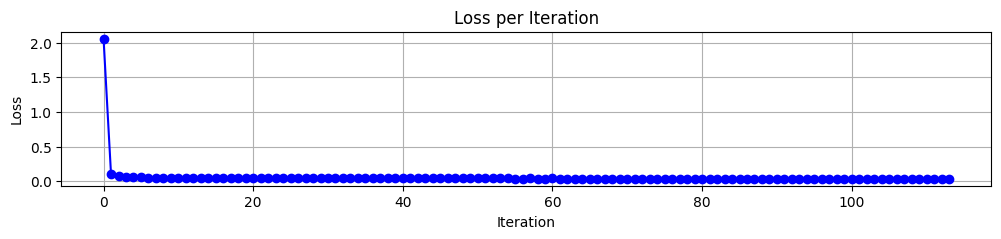

In [29]:
plt.figure(figsize=(12, 2))

# 반복 단위 손실 그래프
plt.plot(train_flatten, label='Train (per iter)', linestyle='-', marker='o', color='blue')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

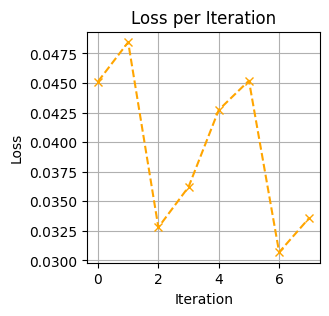

In [30]:
plt.plot(val_flatten, label='Validation (per iter)', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

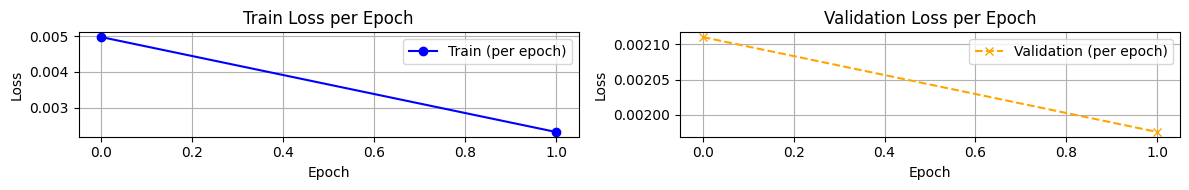

In [31]:
# 1행 2열 레이아웃 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 2))  # 그래프 크기 조정

# Train loss per epoch 그래프
axes[0].plot(train_loss_per_epoch, label='Train (per epoch)', linestyle='-', marker='o', color='blue')
axes[0].set_title("Train Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid()
axes[0].legend()

# Validation loss per epoch 그래프
axes[1].plot(val_loss_per_epoch, label='Validation (per epoch)', linestyle='--', marker='x', color='orange')
axes[1].set_title("Validation Loss per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

# 평가

In [69]:
!pwd

/root/code/unet/base


In [70]:
%cd /root/code/unet/base

/root/code/unet/base


## batch size 16

### loss 추이 관찰

In [71]:
criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet.pth'))

<All keys matched successfully>

In [72]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
len(test_loader)

6025

In [73]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  17%|█▋        | 1020/6025 [00:08<00:42, 117.81it/s]

train loss : 0.037364745933096855


Evaluating:  33%|███▎      | 2016/6025 [00:17<00:34, 117.30it/s]

train loss : 0.033878285395912824


Evaluating:  50%|████▉     | 3012/6025 [00:25<00:25, 117.53it/s]

train loss : 0.03568307526339777


Evaluating:  67%|██████▋   | 4020/6025 [00:33<00:17, 117.58it/s]

train loss : 0.025513253565412015


Evaluating:  83%|████████▎ | 5016/6025 [00:42<00:08, 117.43it/s]

train loss : 0.024662766428198667


Evaluating: 100%|█████████▉| 6012/6025 [00:50<00:00, 117.63it/s]

train loss : 0.022391155462479218


Evaluating: 100%|██████████| 6025/6025 [00:50<00:00, 118.42it/s]


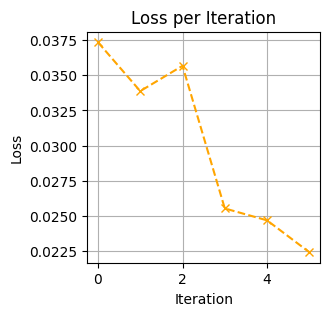

In [74]:
plt.plot(loss_list, label='Test', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

### 16개 개별비교

In [75]:
def visualize_patches_total(X, y, X_hat):

    fig, axes = plt.subplots(3, 16, figsize=(32, 6))  # 3행 16열로 설정
    fig.suptitle("Patches", fontsize=12, y=1.05)  # 전체 제목 추가

    for i in range(X.shape[0]):  # 16개의 이미지만큼 반복
        # X 데이터 시각화
        axes[0, i].imshow(X[i], cmap='gray', vmin=-200, vmax=300)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"X {i+1}", fontsize=12)
        
        # y 데이터 시각화
        axes[1, i].imshow(y[i], cmap='gray', vmin=-200, vmax=300)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"y {i+1}", fontsize=12)
        
        # X_hat 데이터 시각화
        axes[2, i].imshow(X_hat[i], cmap='gray', vmin=-200, vmax=300)
        axes[2, i].axis('off')
        axes[2, i].set_title(f"X_hat {i+1}", fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # 제목 위치 조정
    plt.show()


In [76]:
# 1. 랜덤비교

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
test_iter = iter(test_loader)
len(test_iter)

6025

In [77]:
idx = 400 # 1~6025 여기 안에서 선택
for i in range(idx):
    X_test, y_test = next(test_iter)
    
X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(model(X_test.cuda()).cpu().detach()).numpy() * 500 - 500

In [78]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

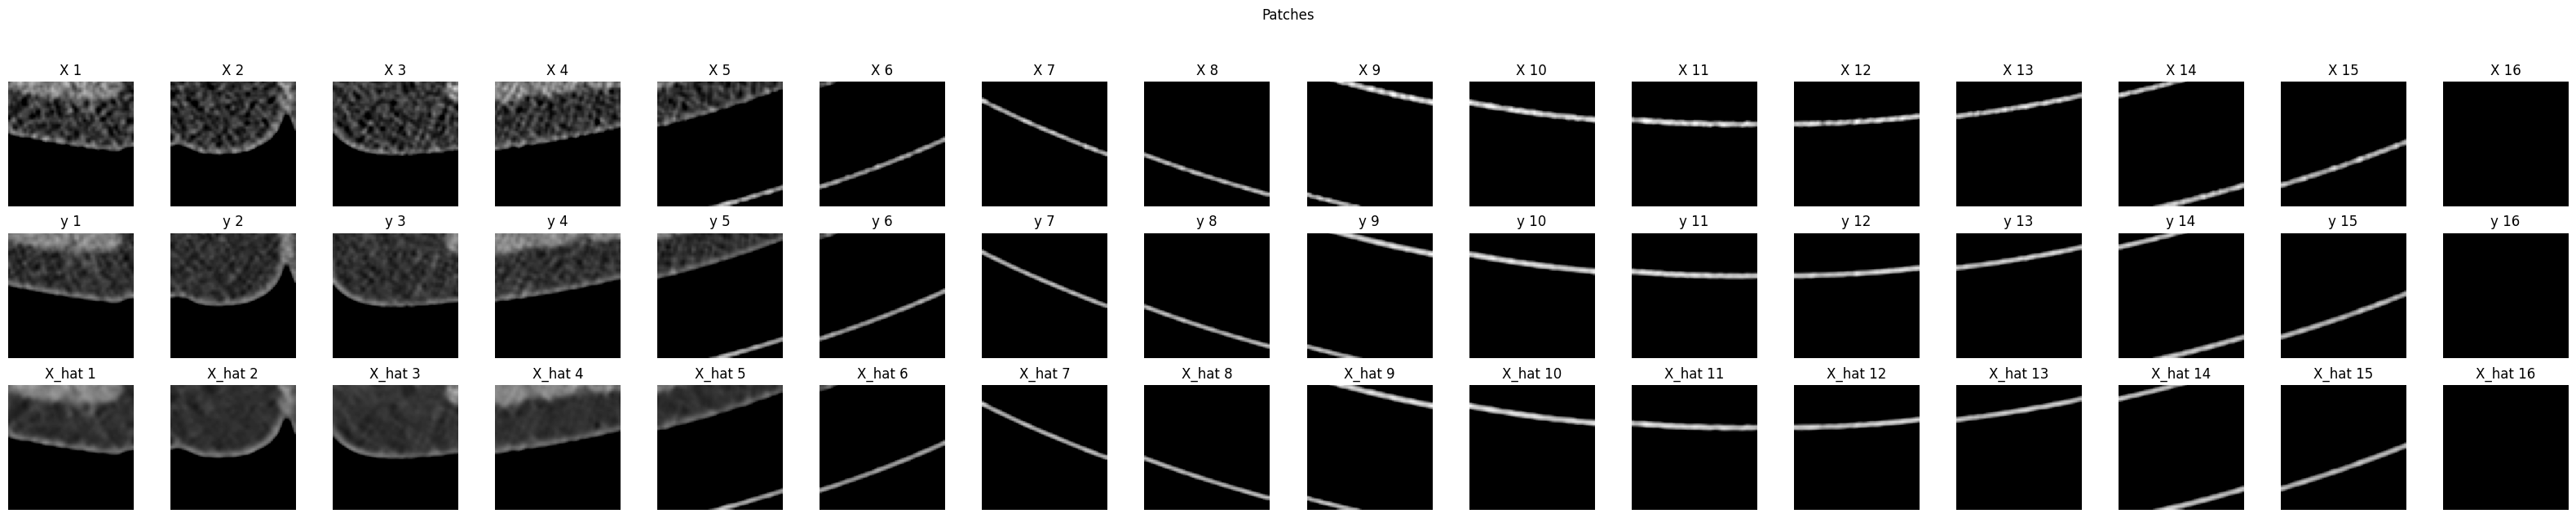

In [79]:
visualize_patches_total(X, y, X_hat)

In [80]:
# 2. 가장 loss가 낮은 값 확인

X_test,y_test,X_hat = best

X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(model(X_test.cuda()).cpu().detach()).numpy() * 500 - 500

In [81]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

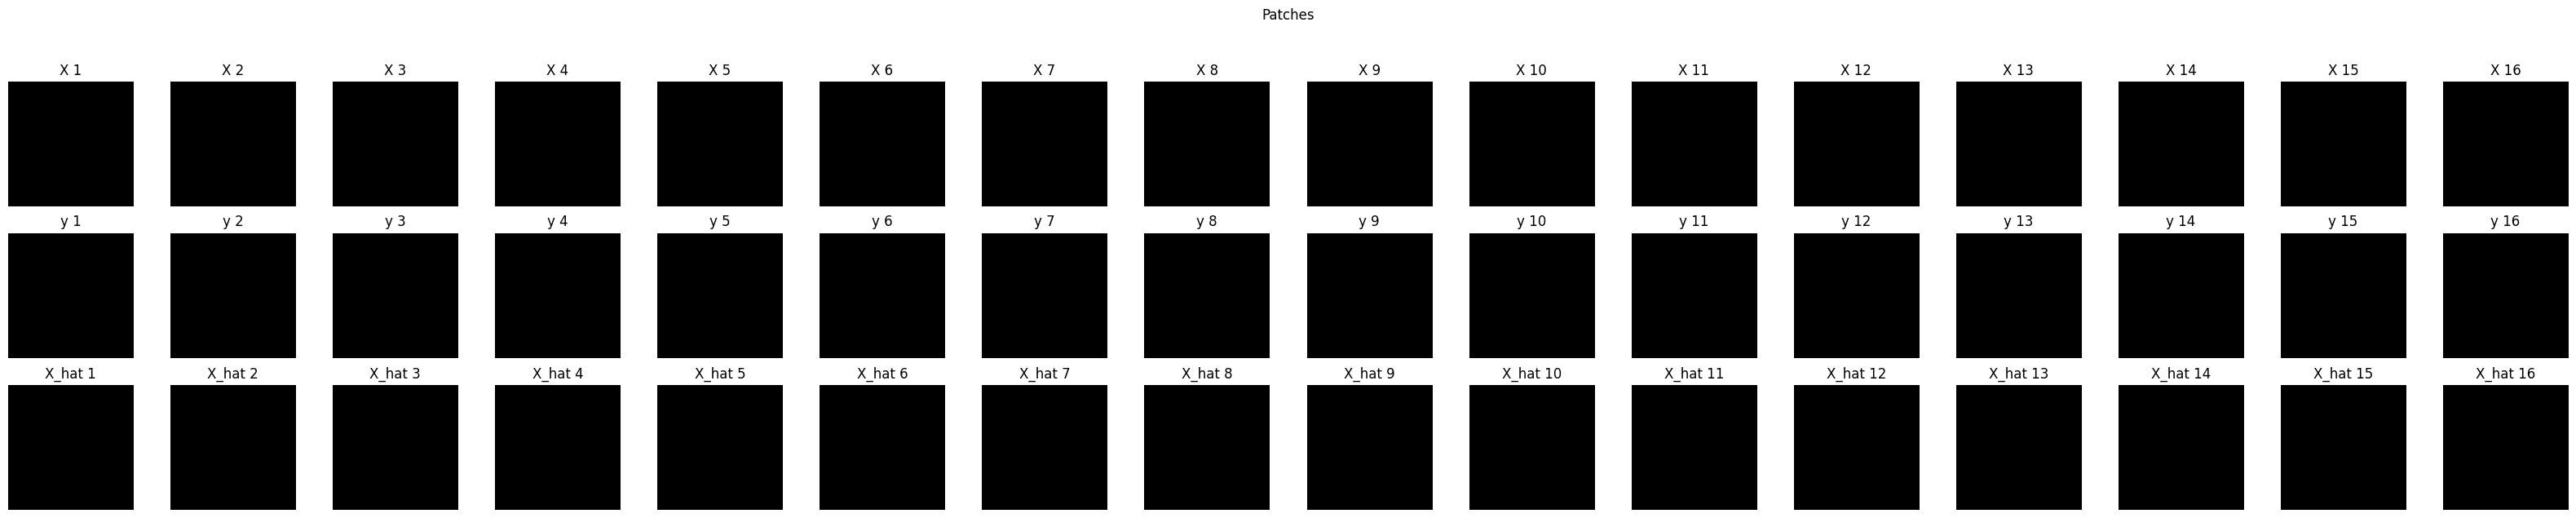

In [82]:
visualize_patches_total(X, y, X_hat)

In [83]:
# 3. 가장 loss가 높은 값 확인

X_test,y_test,X_hat = worst

X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(model(X_test.cuda()).cpu().detach()).numpy() * 500 - 500

In [84]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

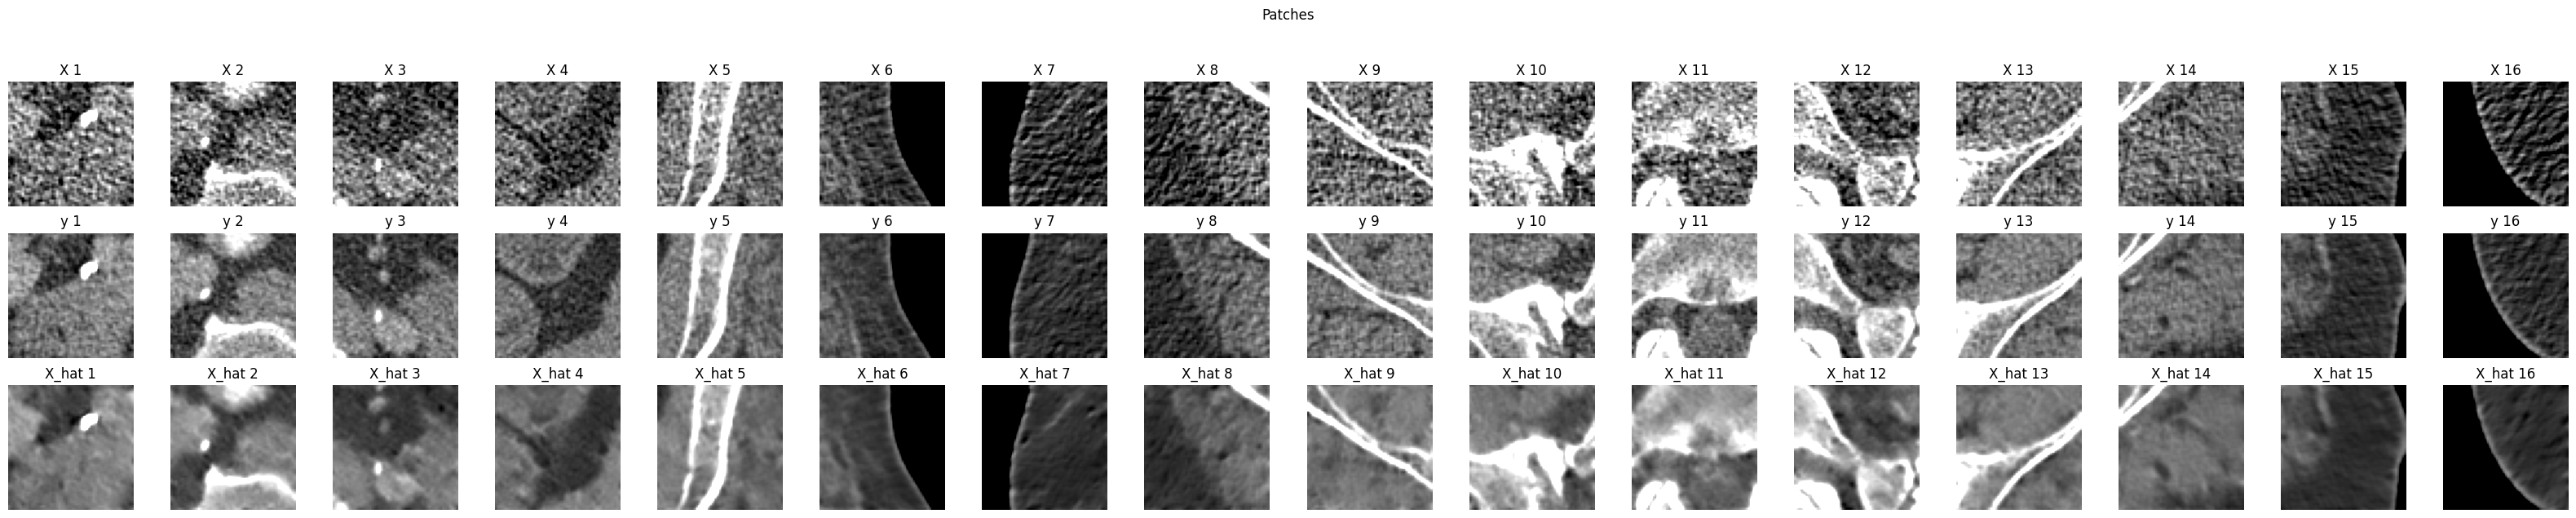

In [85]:
visualize_patches_total(X, y, X_hat)

## batch size = 81

In [86]:
criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet.pth'))

<All keys matched successfully>

In [87]:
test_loader = DataLoader(test_dataset, batch_size=81, shuffle=False, num_workers=0)
len(test_loader)

1190

In [88]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  84%|████████▍ | 1005/1190 [00:39<00:07, 24.98it/s]

train loss : 0.1588205686843721


Evaluating: 100%|██████████| 1190/1190 [00:47<00:00, 25.13it/s]


### 함수정의

In [89]:
def reconstruct_image(prediction, num_patches_per_row=9, patch_size=55):
    # prediction: (81, 1, 55, 55) 크기의 torch 텐서
    num_patches = prediction.shape[0]  # 81개의 패치
    assert prediction.shape == (81, 1, 55, 55) # "패치의 크기가 올바르지 않습니다."
    
    # 최종적으로 1x495x495 크기의 이미지를 만들기 위한 초기화
    final_image = torch.zeros(1, num_patches_per_row * patch_size, num_patches_per_row * patch_size)
    
    # 9x9 배열로 패치 붙이기
    for i in range(num_patches):
        row = i // num_patches_per_row  # 현재 패치의 행 번호
        col = i % num_patches_per_row   # 현재 패치의 열 번호
        
        # 패치를 해당 위치에 붙이기
        final_image[:, 
                    row * patch_size:(row + 1) * patch_size, 
                    col * patch_size:(col + 1) * patch_size] = prediction[i, 0]

    return final_image

In [90]:
def extract_patches(img, patch_size=55, interval=55):
    patches = []
    _, height, width = img.shape
    for y in range(0, height - patch_size + 1, interval):
        for x in range(0, width - patch_size + 1, interval):
            patch = img[:, y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    patches = torch.stack(patches)  # 리스트를 텐서로 변환
    return patches  # 반환 형태는 patch 수 x 1 x 55 x 55

In [91]:
def rescale(img):
    return img*500-500 # -1000부터 2000의 값으로 다시 변환

In [92]:
def trans_img(X):
    return rescale(np.squeeze(reconstruct_image(X)))

In [93]:
X_test,y_test,X_hat = best
trans_img(X_test).min(), trans_img(X_test).max()

(tensor(-1024.), tensor(1862.))

In [94]:
trans_img(X_test).shape

torch.Size([495, 495])

In [95]:
!pwd

/root/code/unet/base


In [96]:
def save_img(X_test, X_hat, y_test, s):
    # X_test 저장
    numpy_X_test = trans_img(X_test).numpy()
    np.save(f'X_test_image{s}.npy', numpy_X_test)
    
    # X_hat 저장
    numpy_X_hat = trans_img(X_hat).numpy()
    np.save(f'X_hat_image{s}.npy', numpy_X_hat)
    
    # y_test 저장
    numpy_y_test = trans_img(y_test).numpy()
    np.save(f'y_test_image{s}.npy', numpy_y_test)

### 1. best

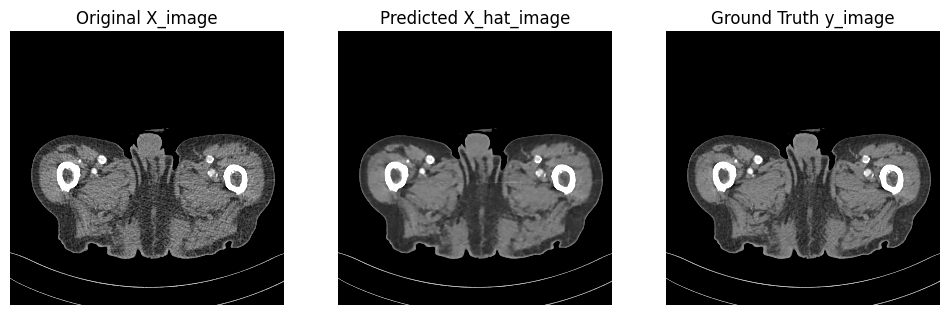

In [97]:
# 1. 가장 좋은 값 가져오기
X_test,y_test,X_hat = best

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(trans_img(X_hat), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(trans_img(y_test), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [98]:
# 이미지 저장

save_img(X_test, X_hat, y_test, 'best')

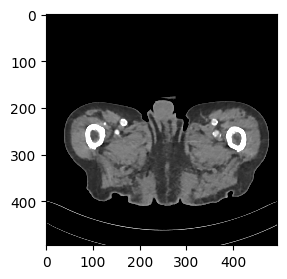

In [99]:
# 불러오기

import numpy as np

s = 'best'
X_test = np.load(f'X_hat_image{s}.npy')

plt.imshow(X_test, cmap='gray', vmin=-200, vmax=300)

### 2. worst

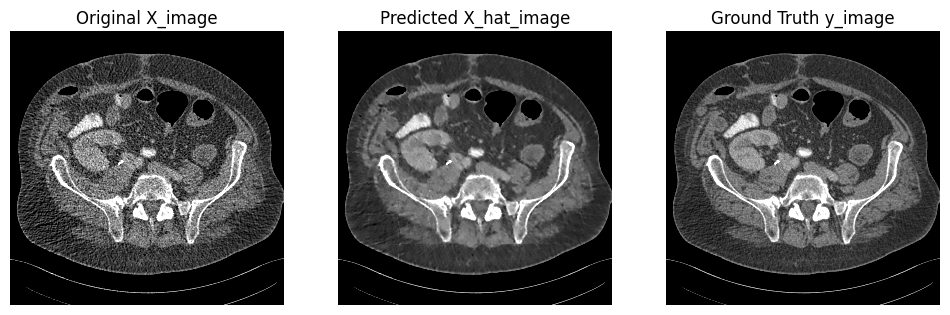

In [100]:
# 2. 가장 나쁜 값 가져오기
X_test,y_test,X_hat = worst

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(trans_img(X_hat), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(trans_img(y_test), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [101]:
# 이미지 저장

save_img(X_test, X_hat, y_test, 'worst')

### 3. 랜덤

In [102]:
import glob
# 3. 랜덤선택

i,j = 0,0
X_dir = sorted(glob.glob(f'/root/Mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
y_dir = sorted(glob.glob(f'/root/Mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]

X_image, y_image = normlize(X_dir), normlize(y_dir)
X_patches = extract_patches(torch.from_numpy(X_image))

X_image.shape, y_image.shape, X_patches.shape

((1, 512, 512), (1, 512, 512), torch.Size([81, 1, 55, 55]))

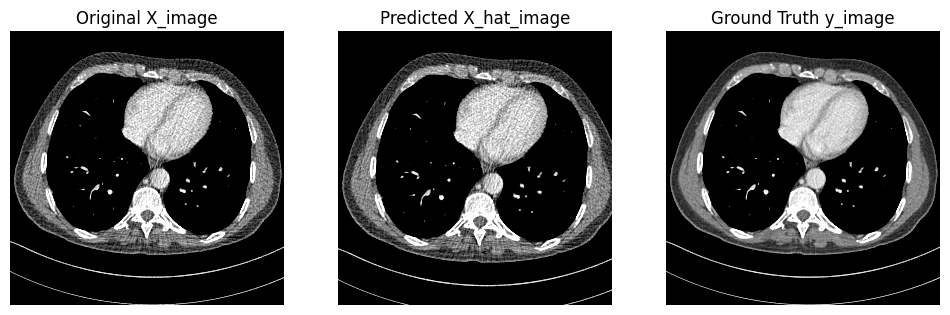

In [103]:
# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(rescale(np.squeeze(X_image)), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(rescale(np.squeeze(reconstruct_image(X_patches))), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(rescale(np.squeeze(y_image)), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [104]:
!pwd

/root/code/unet/base


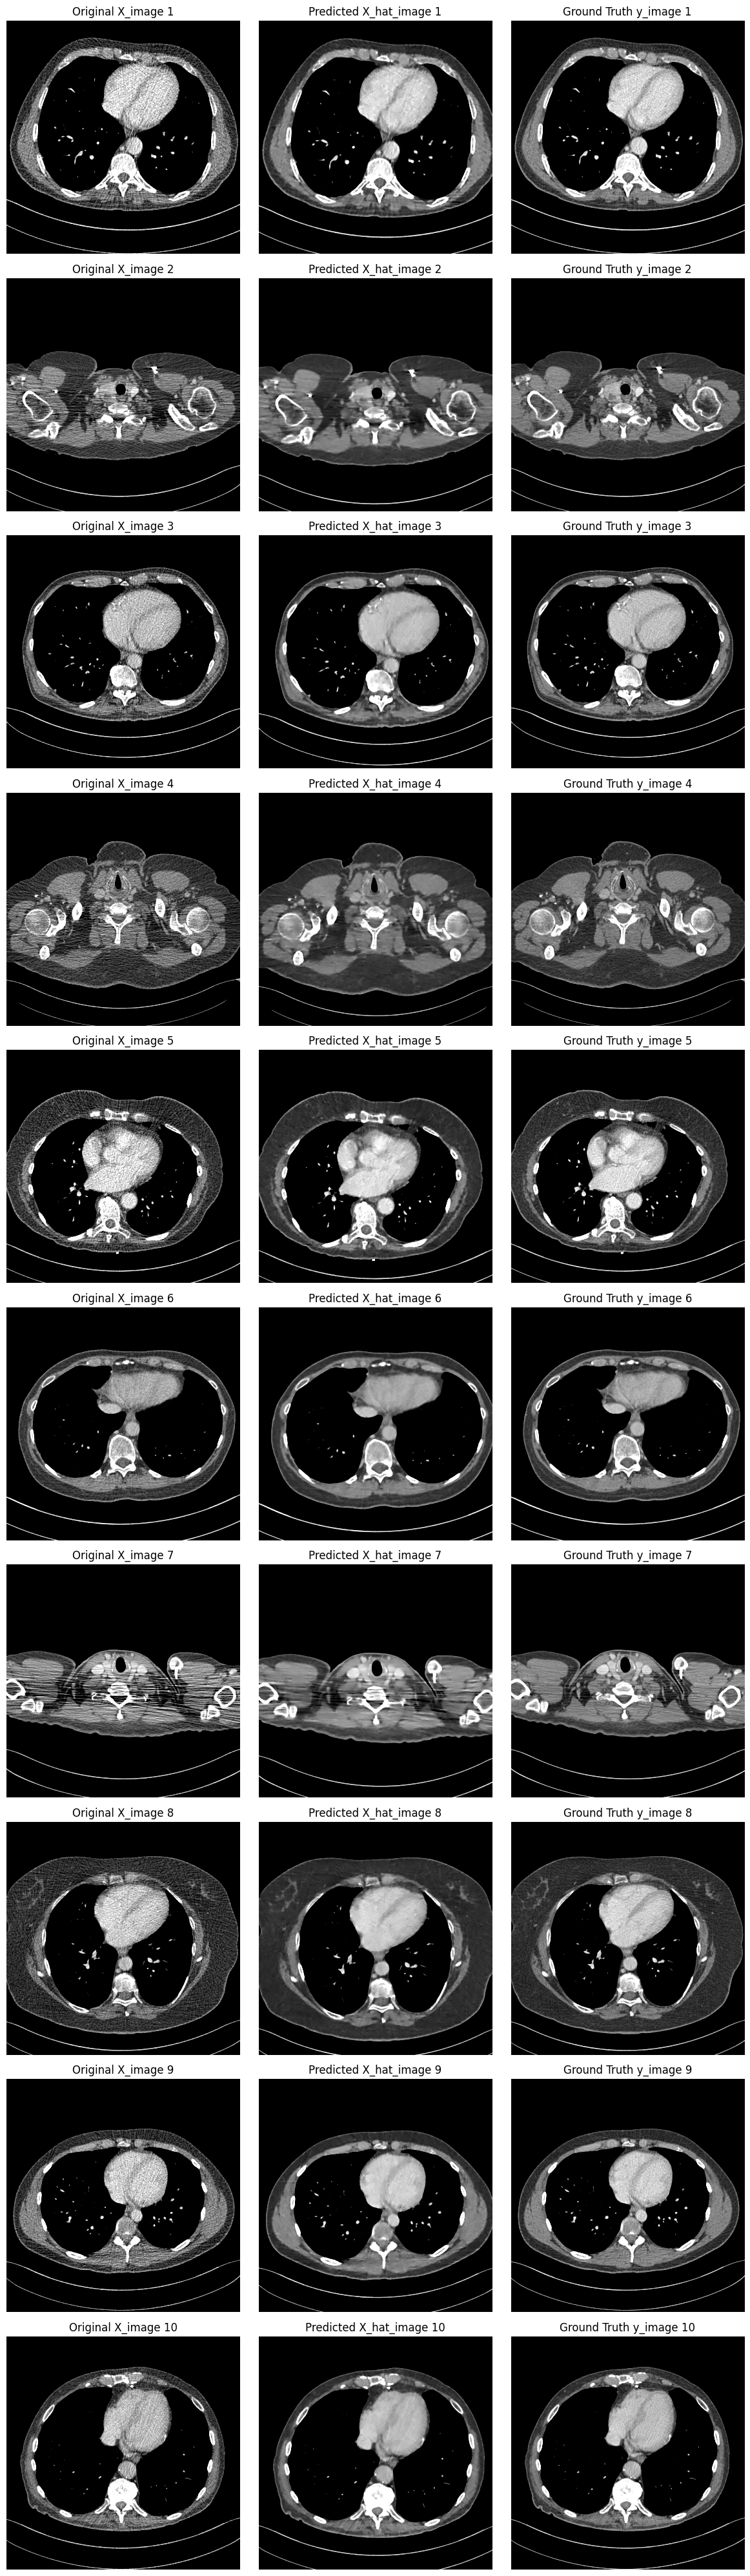

In [105]:
import matplotlib.pyplot as plt
import numpy as np

i, n = 0, 10
L = L_list[i]

# 전체 이미지 배열을 생성
fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))

for i in range(n):
    X_dir = sorted(glob.glob(f'/root/Mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
    y_dir = sorted(glob.glob(f'/root/Mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]
    X_image, y_image = normlize(X_dir), normlize(y_dir)
    X_patches = extract_patches(torch.from_numpy(X_image))
    X_hat_patches = model(X_patches.cuda()).cpu().detach()
    reconstructed_image = reconstruct_image(X_hat_patches)

    # X_image 표시
    axes[i, 0].imshow(rescale(np.squeeze(X_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 0].set_title(f"Original X_image {i+1}")
    axes[i, 0].axis('off')

    # X_hat_image 표시
    axes[i, 1].imshow(rescale(np.squeeze(reconstructed_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 1].set_title(f"Predicted X_hat_image {i+1}")
    axes[i, 1].axis('off')

    # y_image 표시
    axes[i, 2].imshow(rescale(np.squeeze(y_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 2].set_title(f"Ground Truth y_image {i+1}")
    axes[i, 2].axis('off')

# 모든 이미지 저장
plt.tight_layout()
plt.savefig("comparison_images.png", format="png")  # 한번에 저장
plt.show()  # 모든 이미지 표시